Import Packages

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Read data

In [ ]:
df = pd.read_excel('BCV-ds-consultant-take-home-v2.xlsx', sheet_name='Sheet1')

Clean data

In [94]:
# Read the excel file
df.rename(columns={'NUM_EXISTS': 'NUM_EXITS'}, inplace=True)

df = df[['NUM_FUNDING_ROUNDS','EMPLOYEE_COUNT','RAISED_AMOUNT_USD','INVESTMENT_TYPE','LAST_FUNDING_ON','FOUNDED_ON','INVESTOR_COUNT','POST_MONEY_VALUATION_USD','NUM_EXITS']]

df['FOUNDED_ON'] = pd.to_datetime(df['FOUNDED_ON'], errors='coerce', format='%Y-%m-%d')
df['LAST_FUNDING_ON'] = pd.to_datetime(df['LAST_FUNDING_ON'], errors='coerce', format='%Y-%m-%d')
df['DAYS_BETWEEN_FOUNDING_AND_LAST_FUNDING'] = (df['LAST_FUNDING_ON'] - df['FOUNDED_ON']).dt.days.astype(float)
df['EMPLOYEE_COUNT_HIGH'] = df['EMPLOYEE_COUNT'].str.split('-',expand=True)[1].astype(float,errors='ignore')
df['EMPLOYEE_COUNT_LOW'] = df['EMPLOYEE_COUNT'].str.split('-',expand=True)[0].astype(float,errors='ignore')

df = df.fillna(0)

Plot distribution

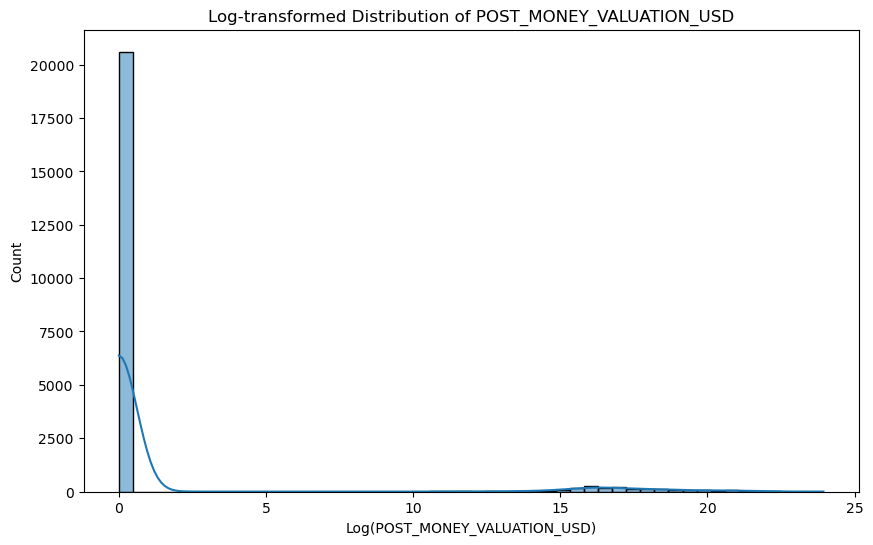

In [117]:
log_valuation = np.log1p(df['POST_MONEY_VALUATION_USD'].dropna())
plt.figure(figsize=(10, 6))
sns.histplot(log_valuation, kde=True, bins=50)  # Using histplot, which is more updated than distplot
plt.title('Log-transformed Distribution of POST_MONEY_VALUATION_USD')
plt.xlabel('Log(POST_MONEY_VALUATION_USD)')
plt.ylabel('Count')
plt.show()

Remove outliers

In [98]:
Q1 = df['POST_MONEY_VALUATION_USD'].quantile(0.25)
Q3 = df['POST_MONEY_VALUATION_USD'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df['POST_MONEY_VALUATION_USD'] >= lower_bound) & (df['POST_MONEY_VALUATION_USD'] <= upper_bound)]


Log transform data

In [99]:
df['LOG_POST_MONEY_VALUATION_USD'] = np.log1p(df['POST_MONEY_VALUATION_USD'])


Create dummy variables for investment type

In [100]:
df = pd.get_dummies(df, columns=['INVESTMENT_TYPE'],drop_first=True)


Create Training/Test Split

In [101]:
X = df.drop(['POST_MONEY_VALUATION_USD', 'LOG_POST_MONEY_VALUATION_USD','EMPLOYEE_COUNT','LAST_FUNDING_ON','FOUNDED_ON'], axis=1)
y = df['LOG_POST_MONEY_VALUATION_USD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


More Data Pre-processing

In [102]:
non_numeric_cols = X_train.select_dtypes(include=['object']).columns

for col in non_numeric_cols:
    X_train[col].replace('unknown', np.nan, inplace=True)
    X_train[col].fillna(X_train[col].mode()[0], inplace=True)
    X_test[col].replace('unknown', np.nan, inplace=True)
    X_test[col].fillna(X_train[col].mode()[0], inplace=True)

X_train.replace('10000+', 10000, inplace=True)
X_test.replace('10000+', 10000, inplace=True)

# Convert 'EMPLOYEE_COUNT_LOW' to float type
X_train['EMPLOYEE_COUNT_LOW'] = X_train['EMPLOYEE_COUNT_LOW'].astype(float)
X_test['EMPLOYEE_COUNT_LOW'] = X_test['EMPLOYEE_COUNT_LOW'].astype(float)

# Now, you can train the XGBoost model as before



Train Model

In [104]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Train RMSE: 4.537241012488818
Test RMSE: 4.489210347096463


Plot Residuals

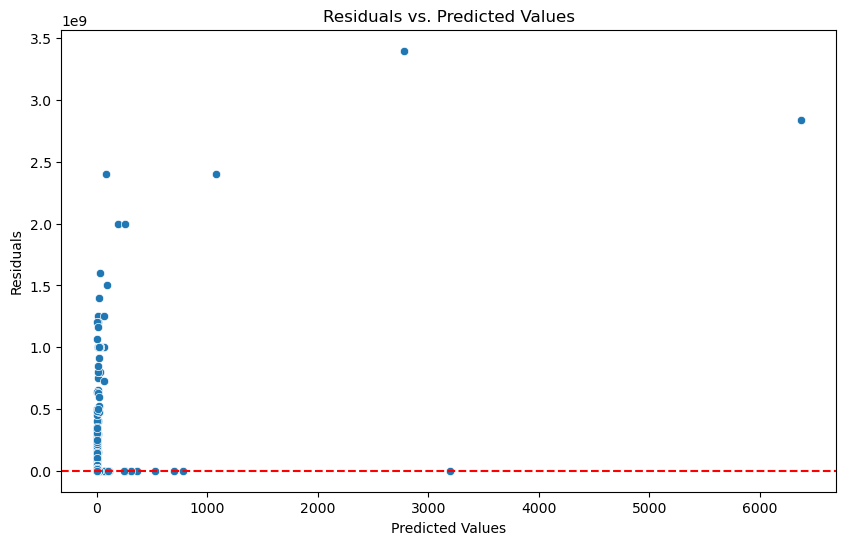

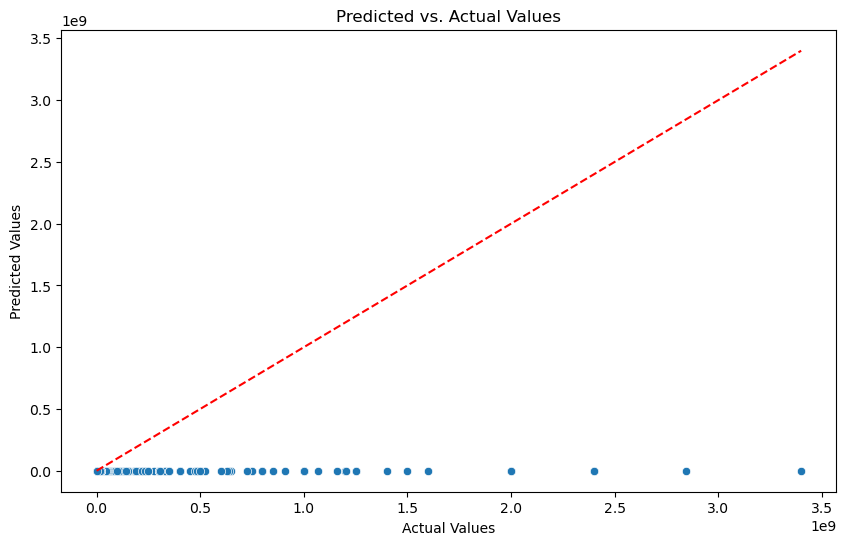

In [106]:
y_pred = model.predict(X_test)

y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

residuals = y_test_original - y_pred_original

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_original, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()



Re-attempt using gradient boosted tree

In [107]:
gbm = xgb.XGBRegressor(
    objective='reg:squarederror',  
    n_estimators=100,              
    learning_rate=0.1,            
    max_depth=5                  
)

gbm.fit(X_train, y_train)

y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Train RMSE: 4.087096368701895
Test RMSE: 4.365691574620613


Plot Residuals of Gradient Boosted Tree Model

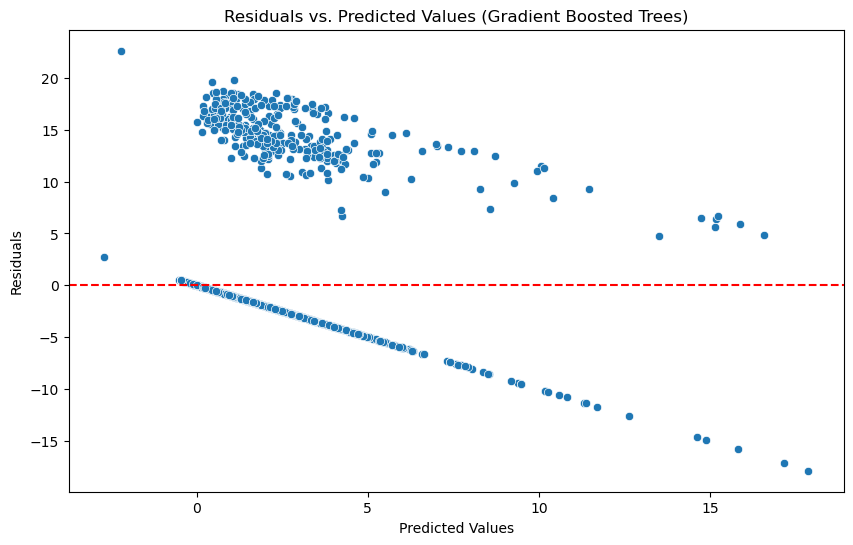

In [108]:
y_pred_gbm = gbm.predict(X_test)

residuals_gbm = y_test - y_pred_gbm

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_gbm, y=residuals_gbm)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values (Gradient Boosted Trees)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


Tune Model

In [109]:
gbm = xgb.XGBRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
best_gbm = grid_search.best_estimator_


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters:  {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.9}


Update model using Best parameters

In [110]:
best_params = grid_search.best_params_

best_gbm = xgb.XGBRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree']
)

best_gbm.fit(X_train, y_train)

y_train_pred_best = best_gbm.predict(X_train)
y_test_pred_best = best_gbm.predict(X_test)

train_rmse_best = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
test_rmse_best = np.sqrt(mean_squared_error(y_test, y_test_pred_best))

print(f"Train RMSE: {train_rmse_best}")
print(f"Test: {test_rmse_best}")


Train RMSE with Best Parameters: 4.181286963951195
Test RMSE with Best Parameters: 4.340076530949669


Plot Residuals of Tuned Model

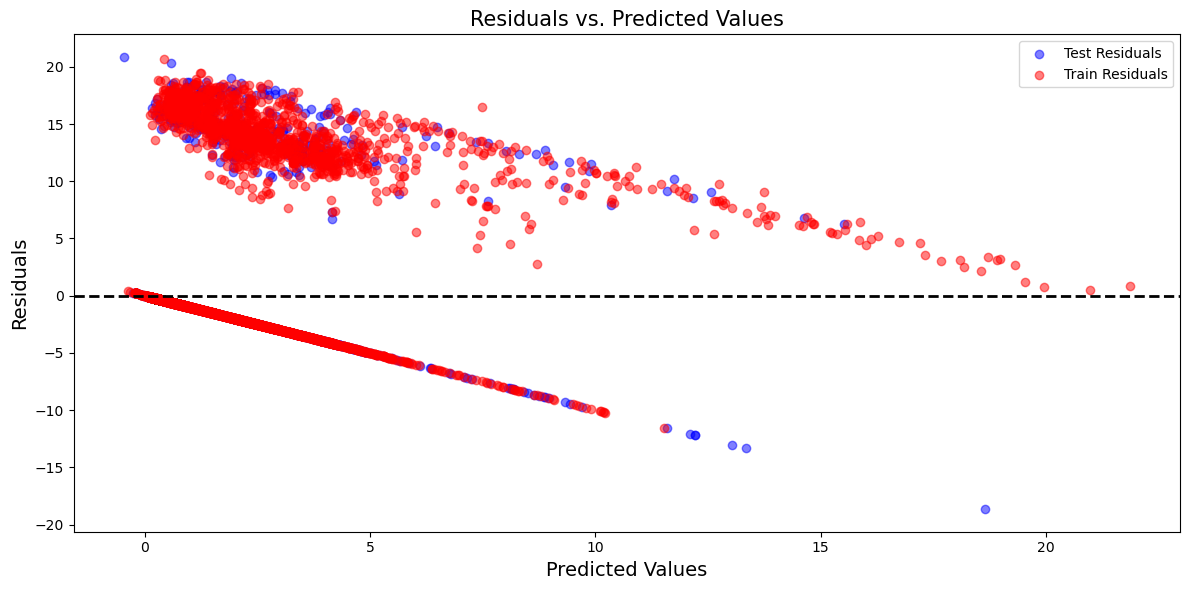

In [111]:
train_residuals = y_train - y_train_pred_best
test_residuals = y_test - y_test_pred_best

plt.figure(figsize=(12, 6))

plt.scatter(y_test_pred_best, test_residuals, color='blue', label='Test Residuals', alpha=0.5)
plt.scatter(y_train_pred_best, train_residuals, color='red', label='Train Residuals', alpha=0.5)

plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

plt.title('Residuals vs. Predicted Values', fontsize=15)
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [112]:
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(test_rmse)

naive_predictions = [y_train.mean()] * len(y_test)
naive_rmse = np.sqrt(mean_squared_error(y_test, naive_predictions))

percentage_improvement = ((naive_rmse - test_rmse) / naive_rmse) * 100


The RMSE of our model is: 4.37
Our model is 4.07% more accurate than a naive model that always predicts the mean.


In [113]:
log_residuals = y_test_pred - y_test

original_residuals = np.exp(log_residuals) - 1  # Subtracting 1 gives the difference relative to the true value

avg_error = np.mean(np.abs(original_residuals))  # Taking absolute to consider magnitude of error

avg_error

On average, the predictions are off by a factor of approximately 22441.01 from the true values.


Plot Importance

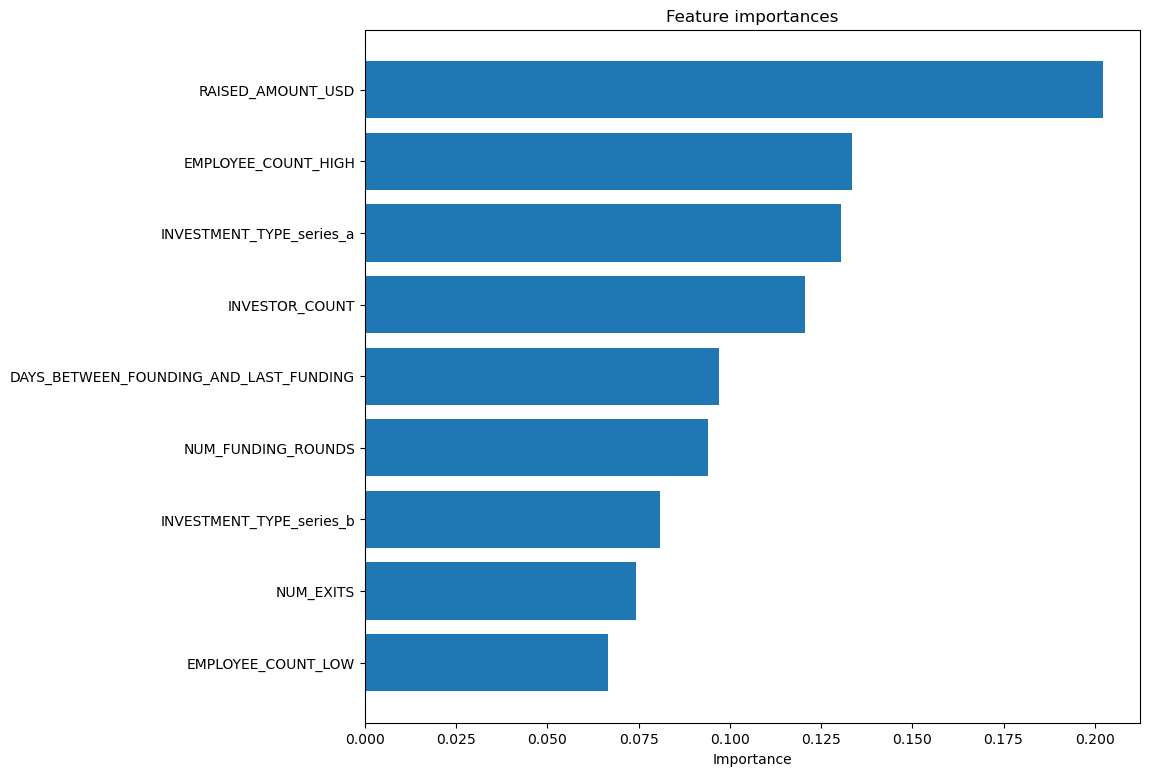

In [115]:
importance = best_gbm.feature_importances_
sorted_idx = importance.argsort()

plt.figure(figsize=(10, len(X.columns)))
plt.barh(X.columns[sorted_idx], importance[sorted_idx], align='center')
plt.xlabel("Importance")
plt.title("Feature importances")
plt.show()


In [116]:
X_train

,NUM_FUNDING_ROUNDS,RAISED_AMOUNT_USD,INVESTOR_COUNT,NUM_EXITS,DAYS_BETWEEN_FOUNDING_AND_LAST_FUNDING,EMPLOYEE_COUNT_HIGH,EMPLOYEE_COUNT_LOW,INVESTMENT_TYPE_series_a,INVESTMENT_TYPE_series_b
2495,5,10000000.0,6.0,0.0,1879.0,100.0,51.0,False,True
12320,1,3000000.0,1.0,0.0,516.0,10.0,1.0,False,False
746,5,10000000.0,9.0,0.0,2102.0,50.0,11.0,False,True
20839,4,30000000.0,5.0,0.0,944.0,100.0,51.0,True,False
10421,6,0.0,4.0,0.0,2082.0,50.0,11.0,False,False
...,...,...,...,...,...,...,...,...,...
11964,3,0.0,1.0,0.0,1635.0,10.0,1.0,False,False
21575,1,6500000.0,3.0,0.0,276.0,10.0,1.0,False,False
5390,1,2600000.0,4.0,0.0,0.0,10.0,1.0,False,False
860,4,500000.0,0.0,0.0,529.0,10.0,1.0,False,False
